![Piggy bank](piggy_bank.jpg)

Personal loans are a lucrative revenue stream for banks. The typical interest rate of a two-year loan in the United Kingdom is [around 10%](https://www.experian.com/blogs/ask-experian/whats-a-good-interest-rate-for-a-personal-loan/). This might not sound like a lot, but in September 2022 alone UK consumers borrowed [around £1.5 billion](https://www.ukfinance.org.uk/system/files/2022-12/Household%20Finance%20Review%202022%20Q3-%20Final.pdf), which would mean approximately £300 million in interest generated by banks over two years!

You have been asked to work with a bank to clean the data they collected as part of a recent marketing campaign, which aimed to get customers to take out a personal loan. They plan to conduct more marketing campaigns going forward so would like you to ensure it conforms to the specific structure and data types that they specify so that they can then use the cleaned data you provide to set up a PostgreSQL database, which will store this campaign's data and allow data from future campaigns to be easily imported. 

They have supplied you with a csv file called `"bank_marketing.csv"`, which you will need to clean, reformat, and split the data, saving three final csv files. Specifically, the three files should have the names and contents as outlined below:

## `client.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `age` | `integer` | Client's age in years | N/A |
| `job` | `object` | Client's type of job | Change `"."` to `"_"` |
| `marital` | `object` | Client's marital status | N/A |
| `education` | `object` | Client's level of education | Change `"."` to `"_"` and `"unknown"` to `np.NaN` |
| `credit_default` | `bool` | Whether the client's credit is in default | Convert to `boolean` data type:<br> `1` if `"yes"`, otherwise `0` |
| `mortgage` | `bool` | Whether the client has an existing mortgage (housing loan) | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0` |

<br>

## `campaign.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `number_contacts` | `integer` | Number of contact attempts to the client in the current campaign | N/A |
| `contact_duration` | `integer` | Last contact duration in seconds | N/A |
| `previous_campaign_contacts` | `integer` | Number of contact attempts to the client in the previous campaign | N/A |
| `previous_outcome` | `bool` | Outcome of the previous campaign | Convert to boolean data type:<br> `1` if `"success"`, otherwise `0`. |
| `campaign_outcome` | `bool` | Outcome of the current campaign | Convert to boolean data type:<br> `1` if `"yes"`, otherwise `0`. |
| `last_contact_date` | `datetime` | Last date the client was contacted | Create from a combination of `day`, `month`, and a newly created `year` column (which should have a value of `2022`); <br> **Format =** `"YYYY-MM-DD"` |

<br>

## `economics.csv`

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `cons_price_idx` | `float` | Consumer price index (monthly indicator) | N/A |
| `euribor_three_months` | `float` | Euro Interbank Offered Rate (euribor) three-month rate (daily indicator) | N/A |

In [360]:
# for data frame compilation and utilities
import pandas as pd

# for numerical computations and types
import numpy as np

# for deleting the output files, if existing, before the whole ETL process is run
import os, glob

In [361]:
# Delete output files, if existing, to start each run with a clean slate
for f in glob.glob("output/*.csv"):
    os.remove(f)

In [362]:
df = pd.read_csv("bank_marketing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

In [363]:
clients_df = df[['client_id', 'age', 'job', 'marital', 'education', 'credit_default', 'mortgage']]
clients_df.head()

,client_id,age,job,marital,education,credit_default,mortgage
0,0,56,housemaid,married,basic.4y,no,no
1,1,57,services,married,high.school,unknown,no
2,2,37,services,married,high.school,no,yes
3,3,40,admin.,married,basic.6y,no,no
4,4,56,services,married,high.school,no,no


In [364]:
print(clients_df.info(),'\n')
clients_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   client_id       41188 non-null  int64 
 1   age             41188 non-null  int64 
 2   job             41188 non-null  object
 3   marital         41188 non-null  object
 4   education       41188 non-null  object
 5   credit_default  41188 non-null  object
 6   mortgage        41188 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.2+ MB
None 



client_id         0
age               0
job               0
marital           0
education         0
credit_default    0
mortgage          0
dtype: int64

In [365]:
# Check that unique id values are equal to the number of rows in the input df (41,188)
assert(len(clients_df['client_id'].unique()) == df.shape[0])

# Check that the minimum and maximum values are 0 and 41187, respectively
assert(clients_df['client_id'].min() == 0)
assert(clients_df['client_id'].max() == (df.shape[0] - 1))

In [366]:
print(clients_df['age'].min(), clients_df['age'].max())

assert(clients_df['age'].min() > 0)
assert(clients_df['age'].max() > 0)

17 98


In [367]:
print(f"unique values for marital: {clients_df['marital'].unique()}.")

unique values for marital: ['married' 'single' 'divorced' 'unknown'].


In [368]:
# Get rows with 'job' containing a dot "." character
# Note the double-escape character needed for str.contains()
clients_job_withdot = clients_df['job'].str.contains('\\.')
print(f"number of job values with '.': {clients_job_withdot.sum()}")
clients_df[ clients_job_withdot ]['job'].unique()

number of job values with '.': 10422


array(['admin.'], dtype=object)

In [369]:

# Replace "."s with "_"s
# Note that escape character is not neeed for str.replace()
clients_df.loc[ clients_job_withdot, 'job'] = clients_df[ clients_job_withdot ]['job'].str.replace(".", "_")

# check that there are no more "job" values with "." character
clients_job_withdot_afterclean = clients_df['job'].str.contains('\\.')
assert(clients_job_withdot_afterclean.sum() == 0)

In [370]:

clients_educ_withdot = clients_df['education'].str.contains('\\.')
print(f"number of education values with '.': {clients_educ_withdot.sum()}")
clients_df[ clients_educ_withdot ]['education'].unique()

number of education values with '.': 39439


array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree'], dtype=object)

In [371]:

clients_df.loc[ clients_educ_withdot, 'education'] = clients_df[ clients_educ_withdot ]['education'].str.replace(".", "_")

# check that there are no more "education" values with "." character
clients_educ_withdot_afterclean = clients_df['education'].str.contains('\\.')
assert(clients_educ_withdot_afterclean.sum() == 0)

In [372]:
print(f"unique education values: {clients_df['education'].unique()}\n")

client_educ_unknown = clients_df['education'] == "unknown"
num_client_educ_unknown = client_educ_unknown.sum()
print(f"number of \"unknown\" education values: {num_client_educ_unknown}")

unique education values: ['basic_4y' 'high_school' 'basic_6y' 'basic_9y' 'professional_course'
 'unknown' 'university_degree' 'illiterate']

number of "unknown" education values: 1731


In [373]:
clients_df.loc[client_educ_unknown, 'education'] = clients_df[ client_educ_unknown ]['education'].replace(to_replace="unknown", value=np.nan)

# check that there are no more "unknown" "education" values,
# and that there is the same number of null values as there were previously unknown values
client_educ_unknown_afterclean = clients_df['education'] == "unknown"
assert(client_educ_unknown_afterclean.sum() == 0)
assert( clients_df['education'].isna().sum() == num_client_educ_unknown )

In [374]:

client_creditdefault_counts_df = clients_df['credit_default'].value_counts()
client_creditdefault_counts_df

no         32588
unknown     8597
yes            3
Name: credit_default, dtype: int64

In [375]:
# Rename the credit_default column to credit_default_obj to reflect its datatype
clients_df = clients_df.rename(columns={"credit_default":"credit_default_obj"})

# Create a new credit_default column, set its values to True or False depending on the old credit_default
clients_df['credit_default'] = (clients_df['credit_default_obj'] == "yes")

# Drop the old credit_default_obj column
clients_df = clients_df.drop(columns=['credit_default_obj'])

# Check that number of 'True' 'credit_default' rows is equal to the number of rows previously "yes",
# and that the number of 'False' rows is equal to the sum of "no"s and "unknowns" previously
assert((clients_df['credit_default'] == True).sum() == client_creditdefault_counts_df["yes"])
assert((clients_df['credit_default'] == False).sum() ==
     (client_creditdefault_counts_df["no"] + client_creditdefault_counts_df["unknown"]))

In [376]:
client_mortgage_counts_df = clients_df['mortgage'].value_counts()
client_mortgage_counts_df

yes        21576
no         18622
unknown      990
Name: mortgage, dtype: int64

In [377]:
# Rename the mortgage column to mortgage_obj to reflect its datatype
clients_df = clients_df.rename(columns={"mortgage":"mortgage_obj"})

# Create a new credit_mortgage column, set its values to True or False depending on the old mortgage_obj
clients_df['mortgage'] = (clients_df['mortgage_obj'] == "yes")

# Drop the old credit_default_obj column
clients_df = clients_df.drop(columns=['mortgage_obj'])

# Check that number of 'True' 'credit_default' rows is equal to the number of rows previously "yes",
# and that the number of 'False' rows is equal to the sum of "no"s and "unknowns" previously
assert((clients_df['mortgage'] == True).sum() == client_mortgage_counts_df["yes"])
assert((clients_df['mortgage'] == False).sum() ==
     (client_mortgage_counts_df["no"] + client_mortgage_counts_df["unknown"]))

In [378]:
clients_df.head()

,client_id,age,job,marital,education,credit_default,mortgage
0,0,56,housemaid,married,basic_4y,False,False
1,1,57,services,married,high_school,False,False
2,2,37,services,married,high_school,False,True
3,3,40,admin_,married,basic_6y,False,False
4,4,56,services,married,high_school,False,False


In [379]:
PATH_TO_CLIENTS_CSV_FILE = 'client.csv'
clients_df.to_csv(PATH_TO_CLIENTS_CSV_FILE, index=False)

In [380]:
# Check first few rows of exported CSV file
try:
    with open(PATH_TO_CLIENTS_CSV_FILE) as csvfile:
        for i in range(0,12):
            print(csvfile.readline())
except FileNotFoundError as e:
    print(f"Error: File '{PATH_TO_CLIENTS_CSV_FILE}' not found.")
    raise SystemExit("Error encountered")

client_id,age,job,marital,education,credit_default,mortgage

0,56,housemaid,married,basic_4y,False,False

1,57,services,married,high_school,False,False

2,37,services,married,high_school,False,True

3,40,admin_,married,basic_6y,False,False

4,56,services,married,high_school,False,False

5,45,services,married,basic_9y,False,False

6,59,admin_,married,professional_course,False,False

7,41,blue-collar,married,,False,False

8,24,technician,single,professional_course,False,True

9,25,services,single,high_school,False,True

10,41,blue-collar,married,,False,False



In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

In [382]:
campaign_df = df[['client_id', 'number_contacts', 'contact_duration',
                'previous_campaign_contacts', 'previous_outcome', 'campaign_outcome', 'month', 'day']]
campaign_df.head()

,client_id,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome,month,day
0,0,1,261,0,nonexistent,no,may,13
1,1,1,149,0,nonexistent,no,may,19
2,2,1,226,0,nonexistent,no,may,23
3,3,1,151,0,nonexistent,no,may,27
4,4,1,307,0,nonexistent,no,may,3


In [383]:
print(campaign_df.info())
campaign_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   client_id                   41188 non-null  int64 
 1   number_contacts             41188 non-null  int64 
 2   contact_duration            41188 non-null  int64 
 3   previous_campaign_contacts  41188 non-null  int64 
 4   previous_outcome            41188 non-null  object
 5   campaign_outcome            41188 non-null  object
 6   month                       41188 non-null  object
 7   day                         41188 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.5+ MB
None


client_id                     0
number_contacts               0
contact_duration              0
previous_campaign_contacts    0
previous_outcome              0
campaign_outcome              0
month                         0
day                           0
dtype: int64

In [384]:
# Check that unique id values are equal to the number of rows in the input df (41,188)
assert(len(campaign_df['client_id'].unique()) == df.shape[0])

# Check that the minimum and maximum values are 0 and 41187, respectively
assert(campaign_df['client_id'].min() == 0)
assert(campaign_df['client_id'].max() == (df.shape[0] - 1))

In [385]:
print(campaign_df['number_contacts'].min(), campaign_df['number_contacts'].max())

assert(campaign_df['number_contacts'].min() >= 0 )
assert(campaign_df['number_contacts'].max() >= 0 )

1 56


In [386]:
print(campaign_df['contact_duration'].min(), campaign_df['contact_duration'].max())

assert(campaign_df['contact_duration'].min() >= 0 )
assert(campaign_df['contact_duration'].max() >= 0 )

0 4918


In [387]:
print(campaign_df['previous_campaign_contacts'].min(), campaign_df['previous_campaign_contacts'].max())

assert(campaign_df['previous_campaign_contacts'].min() >= 0 )
assert(campaign_df['previous_campaign_contacts'].max() >= 0 )

0 7


In [388]:
campaign_prevoutcome_counts_df = campaign_df['previous_outcome'].value_counts()
campaign_prevoutcome_counts_df


nonexistent    35563
failure         4252
success         1373
Name: previous_outcome, dtype: int64

In [389]:
# Rename the previous_outcome column to previous_outcome_obj to reflect its datatype
campaign_df = campaign_df.rename(columns={"previous_outcome":"previous_outcome_obj"})

# Create a new previous_outcome column, set its values to True or False depending on the old previous_outcome_obj
campaign_df['previous_outcome'] = (campaign_df['previous_outcome_obj'] == "success")

# Drop the old previous_outcome_obj column
campaign_df = campaign_df.drop(columns=['previous_outcome_obj'])

# Check that number of 'True' 'previous_outcome' rows is equal to the number of rows previously "success",
# and that the number of 'False' rows is equal to the sum of "nonexistent"s and "failure"s previously
assert((campaign_df['previous_outcome'] == True).sum() == campaign_prevoutcome_counts_df["success"])
assert((campaign_df['previous_outcome'] == False).sum() ==
     (campaign_prevoutcome_counts_df["nonexistent"] + campaign_prevoutcome_counts_df["failure"]))

In [390]:
campaign_campoutcome_counts_df = campaign_df['campaign_outcome'].value_counts()
campaign_campoutcome_counts_df

no     36548
yes     4640
Name: campaign_outcome, dtype: int64

In [391]:
# Rename the campaign_outcome column to campaign_outcome_obj to reflect its datatype
campaign_df = campaign_df.rename(columns={"campaign_outcome":"campaign_outcome_obj"})

# Create a new campaign_outcome column, set its values to True or False depending on the old campaign_outcome_obj
campaign_df['campaign_outcome'] = (campaign_df['campaign_outcome_obj'] == "yes")

# Drop the old campaign_outcome_obj column
campaign_df = campaign_df.drop(columns=['campaign_outcome_obj'])

# Check that number of 'True' 'campaign_outcome' rows is equal to the number of rows previously "yes",
# and that the number of 'False' rows is equal to the sum of "no"s previously
assert((campaign_df['campaign_outcome'] == True).sum() == campaign_campoutcome_counts_df["yes"])
assert((campaign_df['campaign_outcome'] == False).sum() == campaign_campoutcome_counts_df["no"])

In [392]:
print(f"Unique months in campaign_df: {campaign_df['month'].unique()}")
print(f"Min and Max days in campaign_df: {campaign_df['day'].min()}, {campaign_df['day'].max()}")

Unique months in campaign_df: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Min and Max days in campaign_df: 1, 31


In [393]:
# Isolate the date-related columns into a new dataframe
# This is done to avoid creating unecessary new columns in the final dataframe campaign_df
last_contact_date_df = campaign_df[['day']]

# Convert month string to integer equivalent, then store to 'month' column
# Note the usage of `assign()` instead of the usual direct assignment, e.g., df['new_column'] = ...
#   This is done to avoid the SettingWithCopyWarning.
month_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
              'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
last_contact_date_df = last_contact_date_df.assign(month=campaign_df['month'].map(month_dict))

# Set the year to 2022 for all entries
last_contact_date_df = last_contact_date_df.assign(year=2022)

last_contact_date_df.head()

,day,month,year
0,13,5,2022
1,19,5,2022
2,23,5,2022
3,27,5,2022
4,3,5,2022


In [394]:
# Create new column `last_contact_date` from `last_contact_date_df`
# Note the usage of `assign()` instead of the usual direct assignment, e.g., df['new_column'] = ...
#   This is done to avoid the SettingWithCopyWarning.
campaign_df = campaign_df.assign(last_contact_date=pd.to_datetime(arg=last_contact_date_df, format="%Y-%m-%d"))

In [395]:
campaign_df = campaign_df.drop(columns = ['month', 'day'])

# Check that all values in 'last_contact_date' are dates
# in between 2022-01-01(bounded) and 2023-01-01(unbounded)
assert( ((campaign_df['last_contact_date'] >= "2022-01-01") & 
         (campaign_df['last_contact_date'] < "2023-01-01")).sum() == len(campaign_df) )

# Check if month and day columns are not present anymore
assert( ("month" not in campaign_df.columns) and ("day" not in campaign_df.columns) )

campaign_df['last_contact_date'].info(), campaign_df['last_contact_date'].head(), 

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: last_contact_date
Non-Null Count  Dtype         
--------------  -----         
41188 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 321.9 KB


(None,
 0   2022-05-13
 1   2022-05-19
 2   2022-05-23
 3   2022-05-27
 4   2022-05-03
 Name: last_contact_date, dtype: datetime64[ns])

In [396]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   41188 non-null  int64         
 1   number_contacts             41188 non-null  int64         
 2   contact_duration            41188 non-null  int64         
 3   previous_campaign_contacts  41188 non-null  int64         
 4   previous_outcome            41188 non-null  bool          
 5   campaign_outcome            41188 non-null  bool          
 6   last_contact_date           41188 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(4)
memory usage: 1.6 MB


In [397]:
campaign_df.head()

,client_id,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date
0,0,1,261,0,False,False,2022-05-13
1,1,1,149,0,False,False,2022-05-19
2,2,1,226,0,False,False,2022-05-23
3,3,1,151,0,False,False,2022-05-27
4,4,1,307,0,False,False,2022-05-03


In [398]:
PATH_TO_CAMPAIGN_CSV_FILE = 'campaign.csv'
campaign_df.to_csv(PATH_TO_CAMPAIGN_CSV_FILE, index=False)

In [399]:
# Check first few rows of exported CSV file
try:
    with open(PATH_TO_CAMPAIGN_CSV_FILE) as csvfile:
        for i in range(0,12):
            print(csvfile.readline())
except FileNotFoundError as e:
    print(f"Error: File '{PATH_TO_CAMPAIGN_CSV_FILE}' not found.")
    raise SystemExit("Error encountered")

client_id,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date

0,1,261,0,False,False,2022-05-13

1,1,149,0,False,False,2022-05-19

2,1,226,0,False,False,2022-05-23

3,1,151,0,False,False,2022-05-27

4,1,307,0,False,False,2022-05-03

5,1,198,0,False,False,2022-05-05

6,1,139,0,False,False,2022-05-03

7,1,217,0,False,False,2022-05-12

8,1,380,0,False,False,2022-05-21

9,1,50,0,False,False,2022-05-05

10,1,55,0,False,False,2022-05-08



In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

In [401]:
economics_df = df[['client_id', 'cons_price_idx', 'euribor_three_months']]
economics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41188 non-null  int64  
 1   cons_price_idx        41188 non-null  float64
 2   euribor_three_months  41188 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 965.5 KB


In [402]:
economics_df.head()

,client_id,cons_price_idx,euribor_three_months
0,0,93.994,4.857
1,1,93.994,4.857
2,2,93.994,4.857
3,3,93.994,4.857
4,4,93.994,4.857


In [403]:
# Check that unique id values are equal to the number of rows in the input df (41,188)
assert(len(economics_df['client_id'].unique()) == df.shape[0])

# Check that the minimum and maximum values are 0 and 41187, respectively
assert(economics_df['client_id'].min() == 0)
assert(economics_df['client_id'].max() == (df.shape[0] - 1))

In [404]:
print(economics_df['cons_price_idx'].min(), economics_df['cons_price_idx'].max())
economics_df['cons_price_idx'].head()

92.201 94.767


0    93.994
1    93.994
2    93.994
3    93.994
4    93.994
Name: cons_price_idx, dtype: float64

In [405]:
economics_df['euribor_three_months'].min(), economics_df['euribor_three_months'].max()
economics_df['euribor_three_months'].head()

0    4.857
1    4.857
2    4.857
3    4.857
4    4.857
Name: euribor_three_months, dtype: float64

In [406]:
economics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41188 non-null  int64  
 1   cons_price_idx        41188 non-null  float64
 2   euribor_three_months  41188 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 965.5 KB


In [407]:
economics_df.head()

,client_id,cons_price_idx,euribor_three_months
0,0,93.994,4.857
1,1,93.994,4.857
2,2,93.994,4.857
3,3,93.994,4.857
4,4,93.994,4.857


In [408]:
PATH_TO_ECONOMICS_CSV_FILE = 'economics.csv'
economics_df.to_csv(PATH_TO_ECONOMICS_CSV_FILE, index=False)

In [409]:
# Check first few rows of exported CSV file
try:
    with open(PATH_TO_ECONOMICS_CSV_FILE) as csvfile:
        for i in range(0,12):
            print(csvfile.readline())
except FileNotFoundError as e:
    print(f"Error: File '{PATH_TO_ECONOMICS_CSV_FILE}' not found.")
    raise SystemExit("Error encountered")

client_id,cons_price_idx,euribor_three_months

0,93.994,4.857

1,93.994,4.857

2,93.994,4.857

3,93.994,4.857

4,93.994,4.857

5,93.994,4.857

6,93.994,4.857

7,93.994,4.857

8,93.994,4.857

9,93.994,4.857

10,93.994,4.857



## Client Age Distribution
Shows the age profile of customers targeted by the campaign.

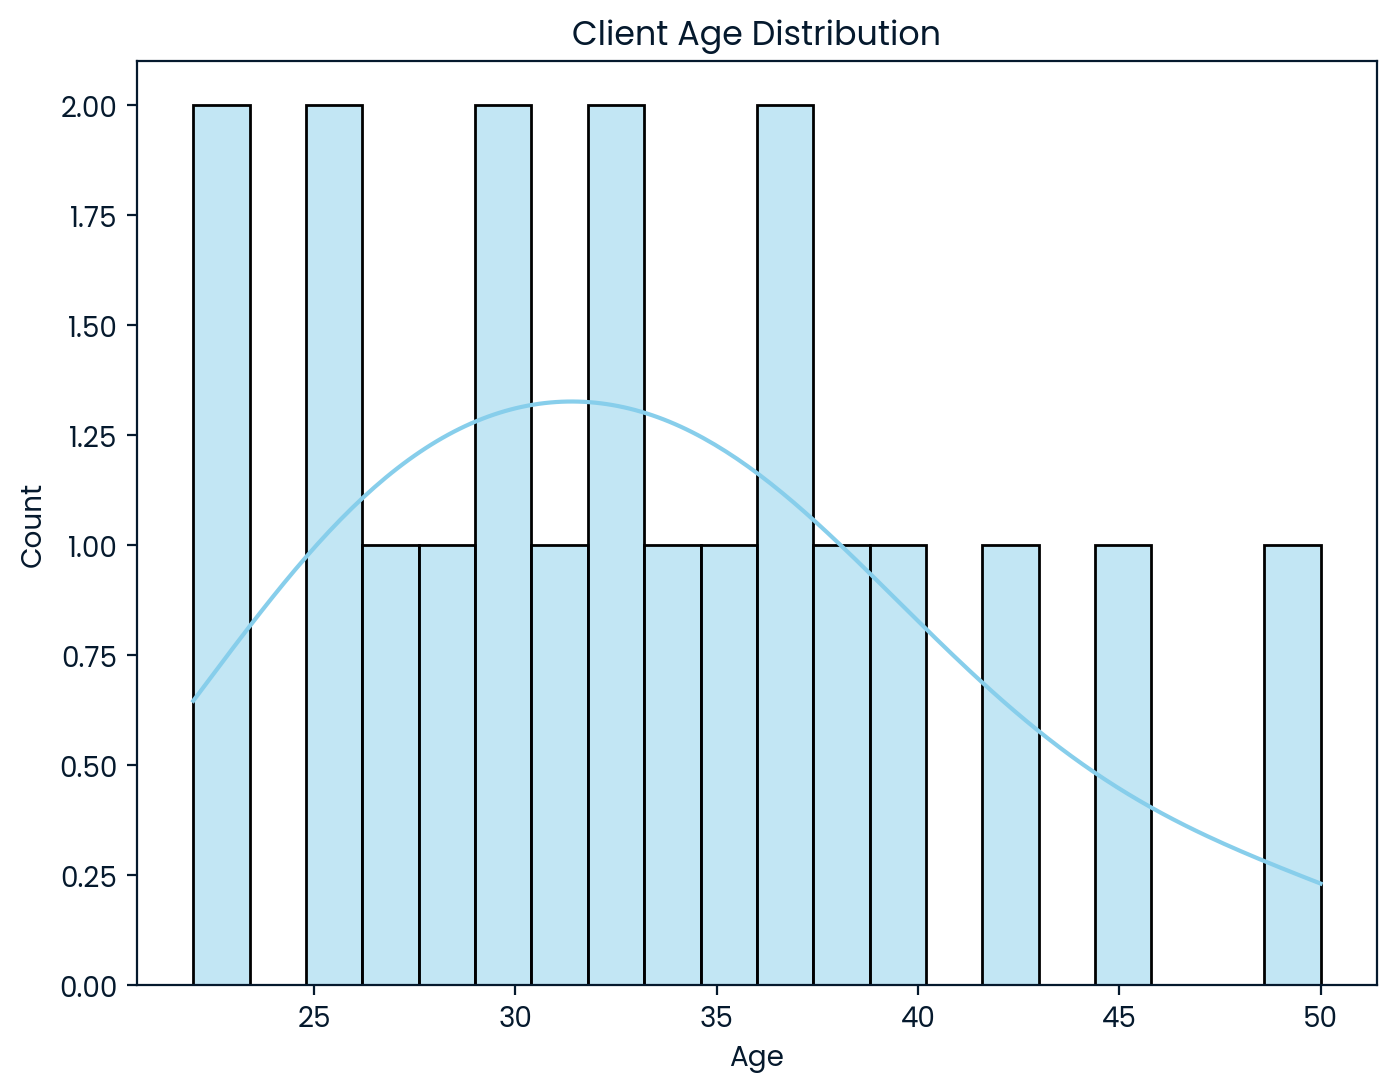

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data to avoid 'df' not defined error
data = {
    'age': [23, 45, 31, 35, 22, 34, 42, 29, 30, 40, 50, 28, 33, 37, 25, 27, 32, 38, 26, 36]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Client Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()